In [331]:
import numpy as np
import pandas as pd
import scipy.stats as si
import matplotlib.pyplot as plt
%matplotlib inline
# import sympy as sy
# import sympy.statistics as systats

In [332]:
num_trials = 1000
num_days = 63
daily_trend = 0 #0.1 / 250
annual_vol = 0.35
daily_vol = annual_vol / 250 ** 0.5
implied_vol = 0.15
implied_daily_vol = implied_vol / 250 ** 0.5
leverage = 3

In [333]:
daily_returns = np.random.normal(loc=daily_trend, scale=daily_vol, size=(num_days, num_trials))
#daily_returns = pd.DataFrame(daily_returns)
path = np.add(daily_returns, 1).cumprod()
#plt.plot(path)

def calc_returns_unhedged(daily_returns):
    end_values = np.cumprod(daily_returns + 1, axis=0)[-1] - 1
    end_values[end_values < 0] = 0
    return np.mean(end_values)
    
calc_returns_unhedged(daily_returns)

0.0723488551423822

In [334]:
def euro_vanilla(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        
    return result

def wrapped_price(S, index):
    return euro_vanilla(S, 1, num_days-index, daily_trend, implied_daily_vol)

euro_vanilla(1, 1, num_days, daily_trend, implied_daily_vol)

0.03003301983306067

In [335]:
#S - spot price
#K - strike price
#T - num_days
#r - risk free rate
#sigma - daily vol


def delta(S, K, T, r, sigma, option = 'call'):

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = si.norm.cdf(d1, 0.0, 1.0)
    if option == 'put':
        result = -si.norm.cdf(-d1, 0.0, 1.0)
        
    return result

def wrapped_delta(S, index):
    return delta(S, 1, num_days-index, daily_trend, implied_daily_vol)

intial_delta = delta(1, 1, num_days, daily_trend, implied_daily_vol)
intial_delta

0.5150165099165304

0.038078730881514804


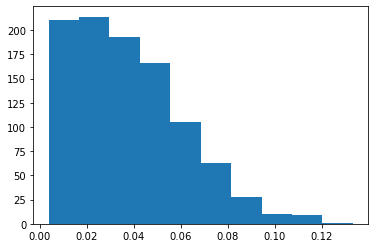

In [336]:
def calc_daily_hedged_pnls(daily_returns, hedge_percent=100):

    daily_prices = np.cumprod(daily_returns + 1, axis=0) # length n
    daily_changes = np.diff(daily_prices, axis=0) # length n - 1
    #use this to provide index for, required for day count
    x, y = np.meshgrid(np.arange(daily_changes.shape[0]), np.arange(daily_changes.shape[1]), indexing='ij')
    
    daily_deltas = np.array(list(map(wrapped_delta, daily_prices, x)))  * hedge_percent / 100
    daily_delta_pnls = daily_changes * daily_deltas
    
    #wrapped_price
    x, y = np.meshgrid(np.arange(daily_returns.shape[0]), np.arange(daily_returns.shape[1]), indexing='ij')
    daily_option_price = np.array(list(map(wrapped_price, daily_prices, x)))
    daily_pnl = np.diff(daily_option_price, axis=0)
    
#     plt.plot(daily_delta_pnls)
#     plt.plot(daily_pnl)
    
    return daily_pnl - daily_delta_pnls

daily_hedged_pnls = calc_daily_hedged_pnls(daily_returns, hedge_percent=100)
final_hedged_pnls = daily_hedged_pnls.cumsum(axis=0)[-1]
print(np.mean(final_hedged_pnls))
plt.hist(final_hedged_pnls);

Mean leveraged ETF PnL: 0.0022878474265148885


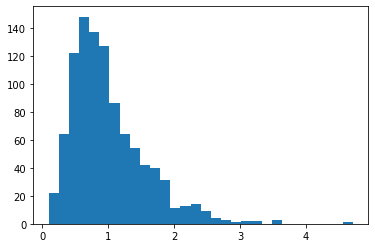

In [341]:
def calc_lev_etf_one_day_change(prior_day_position, one_day_performance):
    prior_day_position = prior_day_position + prior_day_position * one_day_performance

def calc_leveraged_etf_positions(daily_returns):
    
    leveraged_returns = daily_returns * leverage
    for j in range(leveraged_returns.shape[1]):
        leveraged_returns[0][j] += 1
    
    calc_lev_etf_one_day_change = np.frompyfunc(lambda x, y: x + y * x, 2, 1)
    return np.array(calc_lev_etf_one_day_change
                                    .accumulate(leveraged_returns, dtype=np.object, axis=0)
                                    .astype(np.float))
    
    
leveraged_returns_positions = calc_leveraged_etf_positions(daily_returns)
#print(leveraged_returns_positions.shape)
if daily_returns.shape[1] == 1:
    plt.plot(leveraged_returns_positions.squeeze(), label=f'{leverage}x leveraged')
    plt.plot(path, label='1x leveraged');
    plt.legend()
else:
    leveraged_pnls = leveraged_returns_positions[-1,:]
    plt.hist(leveraged_pnls, bins=30)
    print('Mean leveraged ETF PnL: {}'.format(np.mean(leveraged_pnls) - 1))
    

In [338]:
#x + y * x
test_returns = np.array([[0.1], [-0.1], [0.1], [-0.1],[0.1], [-0.1],])
calc_leveraged_etf_positions(test_returns)

array([[1.3     ],
       [0.91    ],
       [1.183   ],
       [0.8281  ],
       [1.07653 ],
       [0.753571]])

In [339]:
test_returns = np.array([[-0.1], [-0.1], [-0.1], [0.1],[0.1], [0.1],])
calc_leveraged_etf_positions(test_returns)

array([[0.7     ],
       [0.49    ],
       [0.343   ],
       [0.4459  ],
       [0.57967 ],
       [0.753571]])

In [340]:
test_returns = np.array([[0.1], [0.1], [0.1], [-0.1],[-0.1], [-0.1],])
calc_leveraged_etf_positions(test_returns)

array([[1.3     ],
       [1.69    ],
       [2.197   ],
       [1.5379  ],
       [1.07653 ],
       [0.753571]])